In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy

from tools import compute_marginals, monitor_progress
from nb_regression_R import extract_errors, extract_warnings, r_MLtheta

### Load preprocessed negative control datasets

In [2]:
datasets = []
with open('datasets/10x/sample1_preprocessed.pickle','rb') as f:
    datasets.append(pickle.load(f))
with open('datasets/indrop/GSM1599501_K562_pure_RNA.csv_preprocessed.pickle','rb') as f:
    datasets.append(pickle.load(f))
with open('datasets/microwellseq/GSM2906413_EmbryonicStemCell_dge.txt.gz_preprocessed.pickle','rb') as f:
    datasets.append(pickle.load(f))

In [3]:
_=[print(d['counts'].shape,' --- ',d['label']) for d in datasets]

(2000, 13025)  ---  2k Chromium control Svensson 2017 (10x v2) - sample 1
(953, 25025)  ---  1k K562_pure_RNA Klein 2015 (inDrop)
(9994, 15069)  ---  Han 2018 EmbryonicStemCell control (MicrowellSeq)


### Use analyical solution for offsetmodel and then fit maximum likelihood $\theta$ with 100 iterations

In [4]:
def solve_offset_model(counts,depths):
    '''computes analytical solution for beta0 per gene (Eq. 4 & 5)'''
    total_sum = np.sum(depths)
    gene_sum = counts.sum(axis=0)
    beta0 = np.array(np.log(gene_sum/total_sum)).flatten()
    
    return beta0

In [5]:
def fit_theta_offsetmodel(counts,max_iter,datalabel,fileprefix=''):
    '''fits the offset model described in Eq.3, and then estimates
       the overdisperson theta on the resulting predictions. 
       saves results to file in fit_results/.'''
    
    n_genes = counts.shape[1]        
    savepath = 'fit_results/%sfit_theta_%s_maxiter%u.pickle' % (fileprefix,datalabel,max_iter)

    depths = np.array(counts.sum(axis=1)).flatten()
    gene_means = np.array(counts.mean(axis=0)).flatten()
    #predict means for each cell/gene
    beta0 = solve_offset_model(counts,depths)
    mu = np.outer(depths,np.exp(beta0))

    #for each gene, feed into R and fit theta
    thetas = np.zeros((n_genes)) * np.nan
    warning_msgs_R = n_genes * [['"fitting error"']]
    errors = n_genes * [None]  
    
    for gene_id in range(counts.shape[1]):

        gene_mu = mu[:,gene_id]
        gene_counts = counts[:,gene_id].toarray()
        
        try:
            theta,warning_msg_R = r_MLtheta(y=gene_counts,mu=gene_mu,max_iter=max_iter)
            thetas[gene_id] = theta            
            warning_msgs_R[gene_id] = warning_msg_R
            
        except Exception as error:            
            errors[gene_id] = dict(gene_id=gene_id,error=error)            
            
        monitor_progress(gene_id,n_genes)

            
    #save
    res = dict(thetas=np.array(thetas),
               beta0=np.array(beta0),
               gene_means=gene_means,
               warning_msgs=extract_warnings(warning_msgs_R),
               errors=extract_errors(errors),
               max_iter=max_iter)
    
    pickle.dump(res,open(savepath, "wb"), protocol=4)

In [6]:
## fit theta per gene in original data and save results as pickle
## 25/35/80 min per datatset, respectively
[fit_theta_offsetmodel(d['counts'],max_iter=100,datalabel=d['protocol']) for d in datasets]

In [7]:
def simulate_control_data(dataset,theta,n_means_simulated,n_simulations,seed):
    '''simulates a number of control datasets with same depths n as the provided
    original dataset, and p's that span the range of p's in the original dataset.
    Counts will be NB distributed with overdispersion parameter theta and mean n*p'''
    
    counts_orig = dataset['counts']
    
    #computing original ns and ps
    ns_orig,ps_orig = compute_marginals(counts_orig)
    ps_orig = ps_orig / np.sum(ps_orig)    

    #compute range of ps
    p_min = min(ps_orig)
    p_max = max(ps_orig)
    #compute ps to use 
    ps_sim = np.logspace(np.log10(p_min),np.log10(p_max),num=n_means_simulated) # limitsminam
    #compute mean as n*p
    mu_sim = np.outer(ns_orig,ps_sim)

    #stimulate
    counts_sim = []

    np.random.seed(seed)    
    for sim_id in range(n_simulations):
        if theta == np.Inf:
            counts = np.random.poisson(mu_sim)
        else:
            nb_p = theta / (theta + mu_sim)           
            counts = np.random.negative_binomial(theta, nb_p)
            
        counts_sim.append(counts)
            
    counts_sim = np.array(counts_sim)
    
    return counts_sim   

In [8]:
def fit_theta_for_simulated_dataset(dataset,thetas,max_iter,seed,n_means_simulated = 50,n_simulations = 1000):
    '''for a given dataset, simulate control datasets with different thetas, and fit theta for each of them.
       results will be in fit_results/control_simulations/'''

    for theta in thetas:
        counts_sim = simulate_control_data(dataset,theta=theta,n_means_simulated=n_means_simulated,n_simulations=n_simulations,seed=seed)

        #fit
        for sim_id in range(n_simulations):
            counts = counts_sim[sim_id,:,:]
            print('fitting simulation %u' % (sim_id))
            datalabel = '%s_truetheta%s_simID%u' % (dataset['protocol'],theta,sim_id)

            fit_theta_offsetmodel(sparse.csr_matrix(counts),max_iter=max_iter,datalabel=datalabel,fileprefix='control_simulations/')

In [9]:
# # simulate control datasets with different thetas, fit theta and save result to file
# # 2h45min / 1h45min / 14h per dataset, respectively
[fit_theta_for_simulated_dataset(d,thetas=[np.Inf, 1000,100,10],max_iter=100,seed=42) for d in datasets]

In [10]:
def load_fits_simulated_dataset(dataset,true_theta,n_simulations,max_iter):
    '''for a given dataset, load theta fits of control simulations'''

      
    thetas = []
    means = []
    warning_msgs = []
    errors = []
    
    #load raw result files
    for sim_id in range(n_simulations):
        datalabel='%s_truetheta%s_simID%u' % (dataset['protocol'],true_theta,sim_id)
        fitpath_sim = 'fit_results/control_simulations/fit_theta_%s_maxiter%u.pickle' % (datalabel,max_iter)            
        fit_sim = pickle.load(open(fitpath_sim,'rb'))

        #if any theta is estimated to be inf, set to fixed large value
        inf_estimates = np.isinf(fit_sim['thetas'])
        if np.any(inf_estimates):
            inf_fill_value = 10**25
            print(dataset['protocol'],'theta = ',true_theta,'simID = ',sim_id,'    %u infs detected, replaced by %.2E' % (sum(inf_estimates),inf_fill_value))
            fit_sim['thetas'][inf_estimates] = inf_fill_value

        #append results to list
        thetas.append(fit_sim['thetas'])
        means.append(fit_sim['gene_means'])
        warning_msgs.append(fit_sim['warning_msgs'])
        errors.append(fit_sim['errors'])

    #re-organize to dict of arrays
    thetas = np.array(thetas)
    means = np.array(means)
    warning_msgs = np.array(warning_msgs)
    errors = np.array(errors)
    
    joined_fit = {}
    joined_fit['errors'] = errors
    joined_fit['thetas'] = thetas
    joined_fit['gene_means'] = means
         
    return joined_fit

In [11]:
def remove_diverged_thetas(means,thetas,errors,clipping_threshold):
    '''identify and remove diverged genes.
       Genes that 
           -have no counts observed
           -had theta estimates with large values
           -had theta estimate zero
           -divergence errors
       are set to np.nan.
       Also returns means of theses genes'''
    
    #identify large-value divergence cases
    thetas_large_idx = thetas > clipping_threshold
    n_thetas_large = np.sum(thetas_large_idx)

    #identify error divergence cases
    inf_errortypes = ['Error in if (t0 < 0) { : missing value where TRUE/FALSE needed\nCalls: <Anonymous> ... <Anonymous> -> withWarnings -> withCallingHandlers -> theta.ml\n',
                      'Error in while ((it <- it + 1) < limit && abs(del) > eps) { : \n  missing value where TRUE/FALSE needed\nCalls: <Anonymous> ... <Anonymous> -> withWarnings -> withCallingHandlers -> theta.ml\n']    
    inf_errors_idx = np.isin(errors,inf_errortypes)
    n_inf_errors = np.sum(inf_errors_idx)

    #identify zero-mean or zero-theta cases
    theta_zero_idx = thetas == 0
    means_zero_idx = means == 0

    #combine removal criteria
    remove_idx = np.where(inf_errors_idx | thetas_large_idx | theta_zero_idx | means_zero_idx)

    #extract means of removed genes
    means_removed_nonzero = means[(inf_errors_idx | thetas_large_idx | theta_zero_idx) & ~means_zero_idx]

    #set removed genes to nan
    thetas[remove_idx] = np.nan
    means[remove_idx] = np.nan
    
    return means,thetas, means_removed_nonzero

In [12]:
letter_position=(-0.12,1.45)
legend_position=(0.6,-0.01)
dotsize=3
title_fontsize = 22
title_fontweight = "bold"

In [13]:
def plot_theta_estimates_orig_vs_simulated(ax,hist_ax,dataset,true_thetas,max_iter=100,n_simulations=1000,markersize=dotsize,clipping_threshold = 10**5,log10jittersize=0.5):    
    '''For a given dataset, plots how well theta estimates agree between estimates from original data and estimates from control data with known theta.'''

    ymin,ymax = [10**-4.5,10**5]
    xmin,xmax = [10**-4,10**3]
    
    #load fit of original data
    datalabel=dataset['protocol']
    fileprefix=''    
    fitpath_orig = 'fit_results/%sfit_theta_%s_maxiter%u.pickle' % (fileprefix,datalabel,max_iter)    
    fit_orig = pickle.load(open(fitpath_orig,'rb'))    
    #unpack
    means_orig = copy.deepcopy(fit_orig['gene_means'] )
    thetas_orig = fit_orig['thetas']
    errors_orig = fit_orig['errors'] 

    #set means and thetas of diverged thetas to nan and recover the  removed mean values
    means_orig, thetas_orig, means_orig_diverged = remove_diverged_thetas(means_orig,thetas_orig,errors_orig,clipping_threshold)
    
    #plot theta estimates for real data
    ax.scatter(means_orig,thetas_orig,s=markersize,color='k',  rasterized=True)
    
    ### compute histogram over all gene means and means of diverged genes
    # setup
    xmin_hist = 10**-3.6
    xmax_hist = xmax
    ymin_hist = clipping_threshold*5
    ymax_hist = ymax
    
    #compute bins
    bins_orig = np.logspace(np.log10(xmin_hist),np.log10(xmax_hist),100)
    binwidths_orig = bins_orig[1:] - bins_orig[:-1]
    bincenters_orig = (bins_orig[1:] + bins_orig[:-1])/2
    left_binedges_orig = bins_orig[:-1]
    
    # compute histograms
    hist_meansOrig_diverged,_ = np.histogram(means_orig_diverged,bins=bins_orig)
    hist_meansOrig_all,_ = np.histogram(fit_orig['gene_means'],bins=bins_orig)
    # normalize diverged cases by all cases
    hist_meansOrig_diverged_normalized = hist_meansOrig_diverged/hist_meansOrig_all

    
    ### plot percentile regions for theta estimates on simulated data
    for true_theta in true_thetas:
        if np.isinf(true_theta):
            theta_label = '\infty'
        else:
            theta_label=true_theta
        
        #load & unpack fits
        fits_sim = load_fits_simulated_dataset(dataset,true_theta,n_simulations,max_iter)        
        means_sim = copy.deepcopy(fits_sim['gene_means'])
        thetas_sim = fits_sim['thetas']
        errors_sim = fits_sim['errors'] 
        
        #handle diverged cases as above
        means_sim, thetas_sim, means_sim_diverged = remove_diverged_thetas(means_sim,thetas_sim,errors_sim,clipping_threshold)
        #get means and percentiles across simulation runs, ignoring diverged cases
        means_mean = np.nanmean(means_sim,axis=0)
        thetas_p5 = np.nanpercentile(thetas_sim,5,axis=0)
        thetas_p95 = np.nanpercentile(thetas_sim,95,axis=0)
        
        #plot percentile region
        fill = ax.fill_between(means_mean,thetas_p5,thetas_p95,alpha=0.7,linewidth=0,label=r'$\theta=%s$'%theta_label)
        
        #get histogram of diverged cases and plot as line
        bins_sim = np.logspace(np.log10(xmin_hist),np.log10(xmax_hist),15)
        bincenters_sim = (bins_sim[1:] + bins_sim[:-1])/2
        hist_meansSim_diverged,_ = np.histogram(means_sim_diverged,bins=bins_sim)
        hist_meansSim_all,_ = np.histogram(fits_sim['gene_means'].flatten(),bins=bins_sim,)
        
        hist_meansSim_diverged_normalized = hist_meansSim_diverged/hist_meansSim_all
        hist_ax.plot(bincenters_sim,hist_meansSim_diverged_normalized*100,linewidth=4,alpha=0.7,clip_on=False)

    # plot
    hist_ax.bar(left_binedges_orig,hist_meansOrig_diverged_normalized*100,binwidths_orig,color='k',align='edge')

    hist_ax.set_xlim([xmin_hist,xmax_hist])
    hist_ax.set_xscale('log')
    hist_ax.set_yticks([0,100])
    hist_ax.set_ylim([0,100])

    hist_ax.set_xticks([0.001,0.1,10,1000])
    hist_ax.set_xticklabels([])
    hist_ax.set_title(dataset['protocol'])

    sns.despine(ax=hist_ax)   
    hist_ax.tick_params(axis='x',          
                        which='minor',      
                        bottom=False,      
                        top=False,         
                        labelbottom=False)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([ymin,ymax])
    ax.set_xlim([xmin,xmax])
    ax.set_xlabel('expression mean')
    ax.set_xticks([0.001,0.1,10,1000])
    sns.despine(ax=ax)
    
    plt.tight_layout(h_pad=0.5)

## Figure S1

<ipython-input-13-b723c3b843d5>:40: RuntimeWarning: invalid value encountered in true_divide
  hist_meansOrig_diverged_normalized = hist_meansOrig_diverged/hist_meansOrig_all


10X theta =  inf simID =  370     1 infs detected, replaced by 1.00E+25
10X theta =  inf simID =  401     1 infs detected, replaced by 1.00E+25


<ipython-input-13-b723c3b843d5>:59: RuntimeWarning: Mean of empty slice
  means_mean = np.nanmean(means_sim,axis=0)
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-13-b723c3b843d5>:40: RuntimeWarning: invalid value encountered in true_divide
  hist_meansOrig_diverged_normalized = hist_meansOrig_diverged/hist_meansOrig_all
<ipython-input-13-b723c3b843d5>:59: RuntimeWarning: Mean of empty slice
  means_mean = np.nanmean(means_sim,axis=0)
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-13-b723c3b843d5>:72: RuntimeWarning: invalid value encountered in true_divide
  hist_meansSim_diverged_normalized = hist_meansSim_diverged/hist_meansSim_all
<ipython-input-13-b723c3b843d5>:72: RuntimeWarning: invalid value encounter

inDrop theta =  100 simID =  855     1 infs detected, replaced by 1.00E+25


<ipython-input-13-b723c3b843d5>:72: RuntimeWarning: invalid value encountered in true_divide
  hist_meansSim_diverged_normalized = hist_meansSim_diverged/hist_meansSim_all
<ipython-input-13-b723c3b843d5>:72: RuntimeWarning: invalid value encountered in true_divide
  hist_meansSim_diverged_normalized = hist_meansSim_diverged/hist_meansSim_all
<ipython-input-13-b723c3b843d5>:40: RuntimeWarning: invalid value encountered in true_divide
  hist_meansOrig_diverged_normalized = hist_meansOrig_diverged/hist_meansOrig_all
<ipython-input-13-b723c3b843d5>:59: RuntimeWarning: Mean of empty slice
  means_mean = np.nanmean(means_sim,axis=0)
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-13-b723c3b843d5>:72: RuntimeWarning: invalid value encountered in true_divide
  hist_meansSim_diverged_normalized = hist_meansSim_diverged/hist_meansSim_all
<ipython-input-13-b7

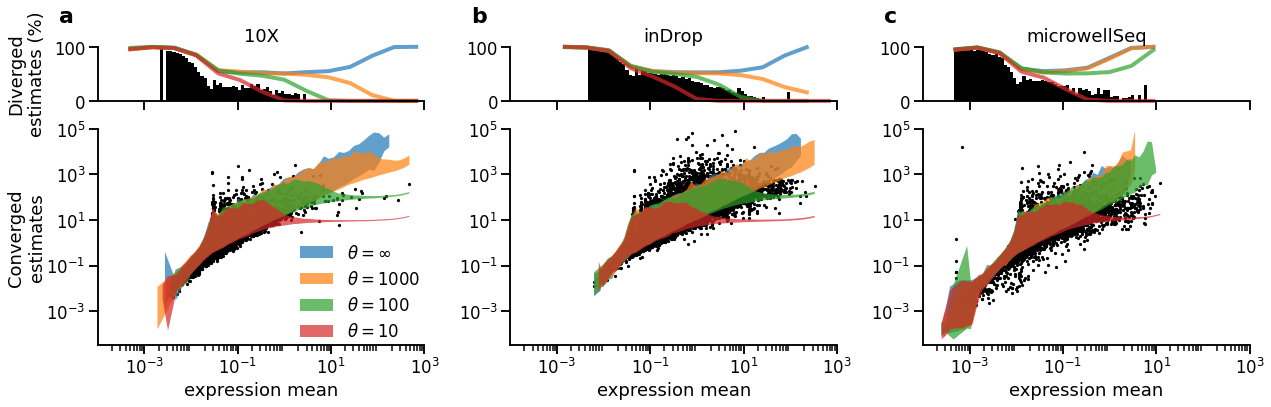

In [14]:
with sns.plotting_context('talk'):
    
    fig,axes = plt.subplots(2,3,figsize=(18,6),sharex=True,sharey=False, gridspec_kw={'height_ratios': [1, 4]})
    letters = ['a','b','c']
    axes_main = axes[1,:]
    axes_hist = axes[0,:]
    
    for i,(ax,hist_ax,letter) in enumerate(zip(axes_main.flatten(),axes_hist.flatten(),letters)):
        
        plot_theta_estimates_orig_vs_simulated(ax,hist_ax,datasets[i],true_thetas=[np.Inf,1000,100,10])
        hist_ax.text(*letter_position,letter,transform=hist_ax.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
        
        if i == 0:
            ax.legend(frameon=False,loc=legend_position)
            hist_ax.set_ylabel('Diverged\nestimates (%)',labelpad=7.5)
            ax.set_ylabel('Converged\nestimates',labelpad=0)
            
    plt.savefig('FigS1.pdf', dpi=300, format=None)


In [15]:
%load_ext watermark

In [16]:
watermark

Last updated: 2021-07-31T15:49:00.746018+02:00

Python implementation: CPython
Python version       : 3.8.0
IPython version      : 7.21.0

Compiler    : GCC 8.3.0
OS          : Linux
Release     : 3.10.0-957.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit



In [17]:
watermark --iversions

scipy     : 1.6.0
seaborn   : 0.11.1
numpy     : 1.20.1
matplotlib: 3.3.3

